In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./"))

# Any results you write to the current directory are saved as output.

['train_post_competition.csv', 'test.csv', 'test_labels.csv.zip', '.ipynb_checkpoints', 'train.csv', 'SVM_2D_SM_C100.0.png', 'audio_train.zip', 'test_post_competition.csv', 'sample_submission.csv', 'SVM_2D_C1e-2.png', 'audio_test.zip', 'SVM_2D_SM_C1.png', 'test_labels.csv', 'SVM_helper.py', 'SVM_2D_C1e-3.png', 'train.csv.zip', 'test.csv.zip', 'xent_term.png', 'sample_submission.csv.zip', '1 - ITBA-Toxic-Comments-SVD.ipynb', 'SVM_2D_SM_C0.01.png', '__pycache__', '0 - Pruebas SVM.ipynb', 'SVM_2D_SM_C10.0.png', 'SVM_2D_SM_C0.001.png', 'SVM_2D_C1.png', 'SVM_2D_C1e2.png', 'SVM_2D_C1e-1.png', 'SVM_2D_SM_C0.1.png', 'unbalancedRL.png', 'SVM_2D_SM_C1000.0.png']


# Análisis de un problema multilabel

Competencia original:

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

# EDA (Exploratory Data Analysis)

In [2]:
folder = './'

In [3]:
train = pd.read_csv(folder+"train.csv")
test = pd.read_csv(folder+"test.csv")
test_labels = pd.read_csv(folder+"test_labels.csv")
submission = pd.read_csv(folder+"sample_submission.csv")

In [4]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [5]:
# Cantidad de observaciones
train.shape

(159571, 8)

## Defino salida del modelo $y$

In [6]:
# Defino y (Salida del modelo)
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
print(y.shape)
print(y[:10])

(159571, 6)
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [7]:
# Dataset muy desbalanceado
toxic_ratio = (y.sum(axis = 1) > 0).sum()/y.shape[0]
print('Porcentaje de comentarios toxicos:', toxic_ratio)

Porcentaje de comentarios toxicos: 0.10167887648758234


In [8]:
# La mayoría son toxic
print(train[list_classes].sum())
print()
print(train[list_classes].sum()/y.shape[0])

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

toxic            0.095844
severe_toxic     0.009996
obscene          0.052948
threat           0.002996
insult           0.049364
identity_hate    0.008805
dtype: float64


In [9]:
# Superposición entre las clases (Multilabel)
for cl in list_classes[1:]:
    N = ((train['toxic'] == 0) & (train[cl] == 1)).sum()
    print(f'Es {cl} pero no es toxic:', N)

Es severe_toxic pero no es toxic: 0
Es obscene pero no es toxic: 523
Es threat pero no es toxic: 29
Es insult pero no es toxic: 533
Es identity_hate pero no es toxic: 103


Se puede ver aca por ejemplo que si es severe_toxic es si o si toxic, pero que insulto puede no ser tóxico por ejemplo

In [10]:
# Baseline (Suponer que siempre elijo zeros (No toxico))
1-(train[list_classes].sum().values/len(train)).mean()

0.9633412921729722

In [11]:
((y == np.zeros_like(y)).sum(axis=0)/len(y)).mean()

0.9633412921729722

In [12]:
train[list_classes].sum().values/len(train)

array([0.09584448, 0.00999555, 0.05294822, 0.00299553, 0.04936361,
       0.00880486])

# Divido entre train y valid

In [13]:
X_train, X_valid, Y_train, Y_valid = train_test_split(train['comment_text'], y, test_size = 0.1)

print(X_train.shape, X_valid.shape)
print(Y_train.shape, Y_valid.shape)

(143613,) (15958,)
(143613, 6) (15958, 6)


# Armo TFIDF

In [14]:
X_train[:10]

118975    "\nThe feedback I am getting is that it looks ...
54920     the several people who have called me that ove...
60952          multiple times, such as        to name a few
45647                           Done - check the testcases.
151893    Petersantos' latest incarnation \n\nHi Admin K...
19082     " August 2010 (UTC)\nI suppose one can assume ...
146939    This all price if you forget about it, then We...
105614                REDIRECT Talk:List of unsolved deaths
18472     "\n\n Headline text \nQuestions and comments\n...
81977     Excellent, thanks for offering to take care of...
Name: comment_text, dtype: object

In [15]:
raw_text_train = X_train.apply(str.lower)
raw_text_valid = X_valid.apply(str.lower)
raw_text_test = test["comment_text"].apply(str.lower)

In [16]:
print(raw_text_train[:10]) # Recordar que train_test_split hace shuffle 

118975    "\nthe feedback i am getting is that it looks ...
54920     the several people who have called me that ove...
60952          multiple times, such as        to name a few
45647                           done - check the testcases.
151893    petersantos' latest incarnation \n\nhi admin k...
19082     " august 2010 (utc)\ni suppose one can assume ...
146939    this all price if you forget about it, then we...
105614                redirect talk:list of unsolved deaths
18472     "\n\n headline text \nquestions and comments\n...
81977     excellent, thanks for offering to take care of...
Name: comment_text, dtype: object


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

max_features = 100000

tfidf_vectorizer = TfidfVectorizer(max_df=0.11, min_df=1,
                                   max_features=max_features,
                                   stop_words='english')

%time tfidf_matrix_train = tfidf_vectorizer.fit_transform(raw_text_train)

CPU times: user 5.19 s, sys: 32 ms, total: 5.22 s
Wall time: 5.22 s


In [18]:
%time tfidf_matrix_valid = tfidf_vectorizer.transform(raw_text_valid)

CPU times: user 548 ms, sys: 0 ns, total: 548 ms
Wall time: 549 ms


In [19]:
count_vectorizer = CountVectorizer(max_df=0.11, min_df=1,
                                   max_features=max_features,
                                   stop_words='english')

%time count_matrix_train = count_vectorizer.fit_transform(raw_text_train)

CPU times: user 5.02 s, sys: 8 ms, total: 5.03 s
Wall time: 5.03 s


In [20]:
tfidf_matrix_train.shape, count_matrix_train.shape

((143613, 100000), (143613, 100000))

# Sparsity

In [21]:
sparsity = 1 - (tfidf_matrix_train>0).sum()/(tfidf_matrix_train.shape[0]*tfidf_matrix_train.shape[1])
print(sparsity)

0.9997615354459555


# Resultados TFIDF

In [22]:
top_10 = np.argsort(tfidf_matrix_train.sum(axis=0))[0,::-1][0,:10].tolist()[0]
feature_names = np.array(tfidf_vectorizer.get_feature_names())
print(feature_names[np.array(top_10)])

['thanks' 'edit' 'think' 'know' 'did' 'user' 'people' 'articles' 'use'
 'thank']


In [23]:
top_10_count = np.argsort(count_matrix_train.sum(axis=0))[0,::-1][0,:10].tolist()[0]
feature_names_count = np.array(count_vectorizer.get_feature_names())
print(feature_names_count[np.array(top_10_count)])

['think' 'know' 'people' 'edit' 'use' 'articles' 'time' 'did' 'user'
 'thanks']


# Truncated-SVD o PCA?

In [87]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
tf_idf_train_svd=svd.fit_transform(tfidf_matrix_train)
tf_idf_valid_svd=svd.transform(tfidf_matrix_valid)

In [25]:
# Esto no va mas
#dense_matrix_train = tfidf_matrix_train.todense()
#dense_matrix_valid = tfidf_matrix_valid.todense()

# Creación del modelo

In [26]:
from keras.models import Sequential
from keras.layers import Dense
from keras import initializers

Using TensorFlow backend.


In [27]:
input_features = tf_idf_train_svd.shape[1]
output_size = Y_train.shape[1]

model_rl = Sequential()
model_rl.add(Dense(output_size, input_dim=input_features, activation='sigmoid', 
                   kernel_initializer=initializers.normal(mean=0, stddev=0.001)))
model_rl.summary()
model_rl.compile('Adam', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 606       
Total params: 606
Trainable params: 606
Non-trainable params: 0
_________________________________________________________________


In [28]:
model_rl.evaluate(tf_idf_valid_svd, Y_valid)

15958/15958 [==============================] - 4s 226us/step


[0.6931656444486571, 0.45849522624058836]

In [29]:
batch_size = 128
epochs = 20
model_rl.fit(tf_idf_train_svd, 
          Y_train, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=1, 
          validation_data=(tf_idf_valid_svd, Y_valid))

Train on 143613 samples, validate on 15958 samples
Epoch 1/20
143613/143613 [==============================] - 4s 31us/step - loss: 0.4803 - acc: 0.9628 - val_loss: 0.3300 - val_acc: 0.9638
Epoch 2/20
143613/143613 [==============================] - 4s 30us/step - loss: 0.2586 - acc: 0.9634 - val_loss: 0.2043 - val_acc: 0.9640
Epoch 3/20
143613/143613 [==============================] - 4s 30us/step - loss: 0.1777 - acc: 0.9636 - val_loss: 0.1541 - val_acc: 0.9644
Epoch 4/20
143613/143613 [==============================] - 4s 30us/step - loss: 0.1430 - acc: 0.9641 - val_loss: 0.1304 - val_acc: 0.9649
Epoch 5/20
143613/143613 [==============================] - 4s 30us/step - loss: 0.1256 - acc: 0.9648 - val_loss: 0.1174 - val_acc: 0.9658
Epoch 6/20
143613/143613 [==============================] - 4s 30us/step - loss: 0.1155 - acc: 0.9656 - val_loss: 0.1093 - val_acc: 0.9667
Epoch 7/20
143613/143613 [==============================] - 4s 31us/step - loss: 0.1090 - acc: 0.9665 - val_loss: 0

# MLP

In [30]:
from keras import regularizers
from keras import initializers
from keras.layers import Activation
from keras import optimizers

In [31]:
default_initializer = initializers.normal(mean=0, stddev=0.01)


In [32]:
input_features = tf_idf_train_svd.shape[1]
output_size = Y_train.shape[1]
hidden_units = 100
lambd = 0 #0.001
model_sig_nn = Sequential()
model_sig_nn.add(Dense(200,
                       input_dim=input_features, 
                       kernel_regularizer=regularizers.l2(lambd), 
                       kernel_initializer=default_initializer,
                       name="Capa_Oculta_1"))
model_sig_nn.add(Activation('sigmoid'))
model_sig_nn.add(Dense(200,
                       input_dim=input_features, 
                       kernel_regularizer=regularizers.l2(lambd), 
                       kernel_initializer=default_initializer,
                       name="Capa_Oculta_2"))
model_sig_nn.add(Activation('sigmoid'))
model_sig_nn.add(Dense(output_size,
                       kernel_regularizer=regularizers.l2(lambd), 
                       kernel_initializer=default_initializer,
                       name="Capa_Salida"))
model_sig_nn.add(Activation('sigmoid', name="output")) 
model_sig_nn.summary()


lr = 0.001 
batch_size = 256
epochs = 10

#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr, decay=0.001)

model_sig_nn.compile(loss = 'binary_crossentropy', optimizer=selectedOptimizer, 
                     metrics=['accuracy']) #auc

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_Oculta_1 (Dense)        (None, 200)               20200     
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
Capa_Oculta_2 (Dense)        (None, 200)               40200     
_________________________________________________________________
activation_2 (Activation)    (None, 200)               0         
_________________________________________________________________
Capa_Salida (Dense)          (None, 6)                 1206      
_________________________________________________________________
output (Activation)          (None, 6)                 0         
Total params: 61,606
Trainable params: 61,606
Non-trainable params: 0
_________________________________________________________________


In [33]:
model_sig_nn.evaluate(tf_idf_valid_svd, Y_valid)

15958/15958 [==============================] - 1s 56us/step


[0.700642003019825, 0.36549066763680776]

In [36]:
history = model_sig_nn.fit(tf_idf_train_svd, 
          Y_train, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=1, 
          validation_data=(tf_idf_valid_svd, Y_valid), 
         )

Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 3s 19us/step - loss: 0.0729 - acc: 0.9767 - val_loss: 0.0713 - val_acc: 0.9773
Epoch 2/10
143613/143613 [==============================] - 3s 19us/step - loss: 0.0728 - acc: 0.9768 - val_loss: 0.0711 - val_acc: 0.9773
Epoch 3/10
143613/143613 [==============================] - 3s 19us/step - loss: 0.0726 - acc: 0.9768 - val_loss: 0.0710 - val_acc: 0.9773
Epoch 4/10
143613/143613 [==============================] - 3s 19us/step - loss: 0.0725 - acc: 0.9769 - val_loss: 0.0711 - val_acc: 0.9775
Epoch 5/10
143613/143613 [==============================] - 3s 19us/step - loss: 0.0723 - acc: 0.9769 - val_loss: 0.0709 - val_acc: 0.9776
Epoch 6/10
143613/143613 [==============================] - 3s 19us/step - loss: 0.0723 - acc: 0.9769 - val_loss: 0.0706 - val_acc: 0.9775
Epoch 7/10
143613/143613 [==============================] - 3s 19us/step - loss: 0.0721 - acc: 0.9770 - val_loss: 0

# T-SNE

In [41]:
toxic_idx=np.any(Y_train==1,axis=-1)
toxic_comments=tf_idf_train_svd[toxic_idx][:500]
toxic_size=toxic_comments.shape[0]
notoxic_idx=[toxic_idx==0][:toxic_size]
notoxic_comments=tf_idf_train_svd[notoxic_idx][:500]
notoxic_size=notoxic_comments.shape[0]
data_tsne=np.vstack([toxic_comments,notoxic_comments])
labels_tsne=[1]*toxic_size+[0]*notoxic_size

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """


In [42]:
print("toxicos ",toxic_size)
print("no toxicos ",notoxic_size)
data_tsne.shape

toxicos  500
no toxicos  500


(1000, 100)

In [43]:
from sklearn.manifold import TSNE
train_embedded = TSNE(n_components=2,perplexity=30,verbose=1,init='random',n_iter=1000,method="exact").fit_transform(data_tsne)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.037061
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.632386
[t-SNE] KL divergence after 1000 iterations: 1.163124


In [44]:
train_embedded.shape

(1000, 2)

In [233]:
from matplotlib.colors import ListedColormap as ListedColormap
from matplotlib import pyplot as plt
colors = ['red','green','blue','purple']
plt.scatter(train_embedded[:,0],train_embedded[:,1],c=labels_tsne,cmap=ListedColormap(colors))
plt.show

NameError: name 'train_embedded' is not defined

In [46]:
train_embedded.shape

(1000, 2)

## SVM

Considerar SVC y Linear SVC. Cómo aplica 

SVC: The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples.

LinearSVC: Also note that for the linear case, the algorithm used in LinearSVC by the liblinear implementation is much more efficient than its libsvm-based SVC counterpart and can scale almost linearly to millions of samples and/or features.

In [221]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(LinearSVC(C=0.7,verbose=True,max_iter=100,random_state=42), n_jobs=-1)
clf.fit(tfidf_matrix_train, Y_train)

OneVsRestClassifier(estimator=LinearSVC(C=0.7, class_weight=None, dual=True,
                                        fit_intercept=True, intercept_scaling=1,
                                        loss='squared_hinge', max_iter=100,
                                        multi_class='ovr', penalty='l2',
                                        random_state=42, tol=0.0001,
                                        verbose=True),
                    n_jobs=-1)

In [222]:
pred=clf.predict(tfidf_matrix_train)

In [223]:
Y_train.sum()

31624

In [224]:
pred.sum()

26991

In [225]:
Y_train.shape

(143613, 6)

In [226]:
6*143613

861678

In [227]:
np.equal(Y_train,pred).sum()/(6*143613)

0.9909351288996586

In [228]:
pred=clf.predict(tfidf_matrix_valid)

In [229]:
Y_valid.sum()

3474

In [230]:
pred.sum()

2591

In [231]:
Y_valid.shape

(15958, 6)

In [232]:
np.equal(Y_valid,pred).sum()/(6*15958)

0.9821719513723525

# Curva ROC

In [ ]:
pred_train=model_sig_nn.predict(tf_idf_train_svd)
pred_valid=model_sig_nn.predict(tf_idf_valid_svd)

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

print(roc_auc_score(Y_train, pred_train, average='macro'))
print(roc_auc_score(Y_valid, pred_valid, average='macro'))

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = Y_valid.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_valid[:, i], pred_valid[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(Y_valid.ravel(), pred_valid.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

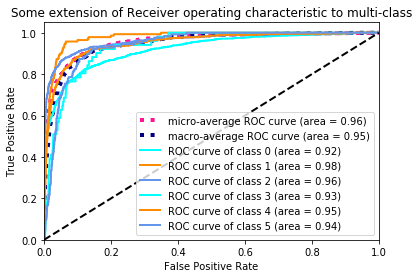

In [40]:
from matplotlib import pyplot as plt
# Compute macro-average ROC curve and ROC area
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()